**Author:** Raoul Malm

**Abstract:** 

Given are 4750 labeled images (1.73GB) showing plants of 12 different types, the goal is to classify correctly the species shown on the 794 images (91MB) of the test set. All images are quadratic but vary in size. We resize them such that each image has the shape (299,299,3). Next, we detect and segment the plant parts of the images, then normalize them such that each pixel is defined on the range [-1,1]. An optional step is to generate new images through rotations, translations and axis flippings, augmenting the original data. All images are then fed into a pretrained Xception model provided by keras and we extract 2048 bottleneck features for each image. Having computed these features once, we train and validate a basic logistic regression, random forest and fully connected neural network model. Finally, we predict the species classes of the test images and write the submission file. Note, that this work demonstrates just a quick and basic implementation and is not fine-tuned.

**Results:**  

- Using a subset of 200 samples of each species for training and validation with a 90%/10% split, we can achieve an accuracy of 88.33% on the validation set. This takes roughly 30 minutes within the kaggle environment.
- Using all labeled data for training and making use of little data augmentation, we can obtain an accuracy of 90.06% on the test set. This takes several hours on my average laptop CPU. If you have more computer power you can easily improve these results.

**Outline:**

1. Libraries and settings
2. Analyze data
3. Manipulate data
4. Extract bottleneck features from Xception
5. Train and validate models
6. Predict species and submit test results

**References:** 

[Seedlings - Pretrained keras models by beluga](https://www.kaggle.com/gaborfodor/seedlings-pretrained-keras-models)  
[Plant Seedlings Fun with Computer Vision by Gábor Vecsei](https://www.kaggle.com/gaborvecsei/plant-seedlings-fun-with-computer-vision)



# 1. Libraries and settings

In [1]:
import tensorflow as tf
from keras.applications import xception
from keras.preprocessing import image 
import keras.preprocessing.image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn.ensemble
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
from glob import glob
import cv2
import os
import seaborn as sns
import mpl_toolkits.axes_grid1
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

# start timer
global_start = datetime.datetime.now();

# validation set size
valid_set_size_percentage = 10; # default = 10%

# kaggle
running_on_kaggle = True # set True when running on kaggle

# train data
take_only_samples_of_train_data = True; # set False to train on all train data
num_samples_of_train_data_per_species = 200 # < 221, ignored if take_only_samples_of_train_data = True
load_bf_of_train_data = False # set True to load bottleneck features from file

# test data
take_only_samples_of_test_data = False; # set False to predict on all test data
num_samples_of_test_data = 200 # < 794, ignored if take_only_samples_of_test_data = True
load_bf_of_test_data = False # set True to load bottleneck features from file

# augmented images
use_aug_data = False # set True to use augmented images
load_bf_of_aug_data = True # set True to load bottleneck features from file

# show plots
show_plots = True # set False to reduce notebook running time

# overview of directories
print('current directory:')
!ls  
print('\nparent directory:')
!ls ..  

Using TensorFlow backend.


current directory:
__output__.json   __results___files		  custom.css
__results__.html  __temp_notebook_source__.ipynb

parent directory:
config	input  lib  working


# 2. Analyze Data
- 12 different plant species
- at least 211 images of each species => in total 4750 in training set
- image sizes vary strongly => resize images to (299,299,3) for Xception input

In [2]:
# input directory
print('input directory:')
!ls ../input/plant-seedlings-classification
print('\nfolders containing images of the corresponding species:')
!ls ../input/plant-seedlings-classification/train

input directory:
sample_submission.csv  test  train

folders containing images of the corresponding species:
Black-grass  Common Chickweed  Loose Silky-bent   Shepherds Purse
Charlock     Common wheat      Maize		  Small-flowered Cranesbill
Cleavers     Fat Hen	       Scentless Mayweed  Sugar beet


In [3]:
## read train and test data

# directories
cw_dir = os.getcwd()
data_dir = '../input/plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# different species in the data set
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
           'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed',
           'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)

# print number of images of each species in the training data
for sp in species:
    print('{} images of {}'.format(len(os.listdir(os.path.join(train_dir, sp))),sp))
    
# read all train data
train = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train.append(['train/{}/{}'.format(sp, file), file, species_id, sp])
train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species_id', 'species'])
print('')
print('train_df.shape = ', train_df.shape)

# read all test data
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test_df = pd.DataFrame(test, columns=['filepath', 'file'])
print('test_df.shape = ', test_df.shape)

# function to read an image 
def read_image(filepath, target_size=None):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), target_size, interpolation = cv2.INTER_AREA)
    #img = image.load_img(os.path.join(data_dir, filepath),target_size=target_size)
    #img = image.img_to_array(img)
    return img


263 images of Black-grass
390 images of Charlock
287 images of Cleavers
611 images of Common Chickweed
221 images of Common wheat
475 images of Fat Hen
654 images of Loose Silky-bent
221 images of Maize
516 images of Scentless Mayweed
231 images of Shepherds Purse
496 images of Small-flowered Cranesbill
385 images of Sugar beet

train_df.shape =  (4750, 4)
test_df.shape =  (794, 2)


In [4]:
## get all image shapes: this is time-consuming, therefore I have deactivated
## the code. The results are included below and show that all
## images are quadratic, but their size can be very different. 

if False:
    train_df['image_heigth'] = 0
    train_df['image_width'] = 0
    train_df['image_channel'] = 0

    #get all image shapes
    for i in range(len(train_df)):
        img = read_img(train_df.filepath.values[i])
        train_df.loc[i,'image_heigth'] = img.shape[0]
        train_df.loc[i,'image_width'] = img.shape[1]
        train_df.loc[i,'image_channel'] = img.shape[2]

    test_df['image_heigth'] = 0
    test_df['image_width'] = 0
    test_df['image_channel'] = 0

    # get all image shapes
    for i in range(len(test_df)):
        img = read_img(test_df.filepath.values[i])
        test_df.loc[i,'image_heigth'] = img.shape[0]
        test_df.loc[i,'image_width'] = img.shape[1]
        test_df.loc[i,'image_channel'] = img.shape[2]


In [5]:
# train data
#print(train_df.describe())
train_df.head()

#         species_id  image_heigth  image_width  image_channel
# count  4750.000000   4750.000000  4750.000000         4750.0
# mean      5.669263    370.730105   371.465895            3.0
# std       3.311364    318.649607   323.275012            0.0
# min       0.000000     49.000000    49.000000            3.0
# 25%       3.000000    140.000000   140.000000            3.0
# 50%       6.000000    266.500000   266.500000            3.0
# 75%       8.000000    507.000000   507.750000            3.0
# max      11.000000   3457.000000  3991.000000            3.0

,filepath,file,species_id,species
0,train/Black-grass/3de7650a2.png,3de7650a2.png,0,Black-grass
1,train/Black-grass/2ee4dad8c.png,2ee4dad8c.png,0,Black-grass
2,train/Black-grass/05eedce4d.png,05eedce4d.png,0,Black-grass
3,train/Black-grass/6b9ebf8cc.png,6b9ebf8cc.png,0,Black-grass
4,train/Black-grass/e5a6e8ebc.png,e5a6e8ebc.png,0,Black-grass


In [6]:
# test data
#print(test_df.describe())
test_df.head()

#        image_heigth  image_width  image_channel
# count    794.000000   794.000000          794.0
# mean     269.492443   269.492443            3.0
# std       43.109211    43.109211            0.0
# min      200.000000   200.000000            3.0
# 25%      232.000000   232.000000            3.0
# 50%      267.000000   267.000000            3.0
# 75%      307.000000   307.000000            3.0
# max      349.000000   349.000000            3.0

,filepath,file
0,test/f4234cf4f.png,f4234cf4f.png
1,test/550a8b7e6.png,550a8b7e6.png
2,test/30ad31220.png,30ad31220.png
3,test/abc331628.png,abc331628.png
4,test/78b1bf91a.png,78b1bf91a.png


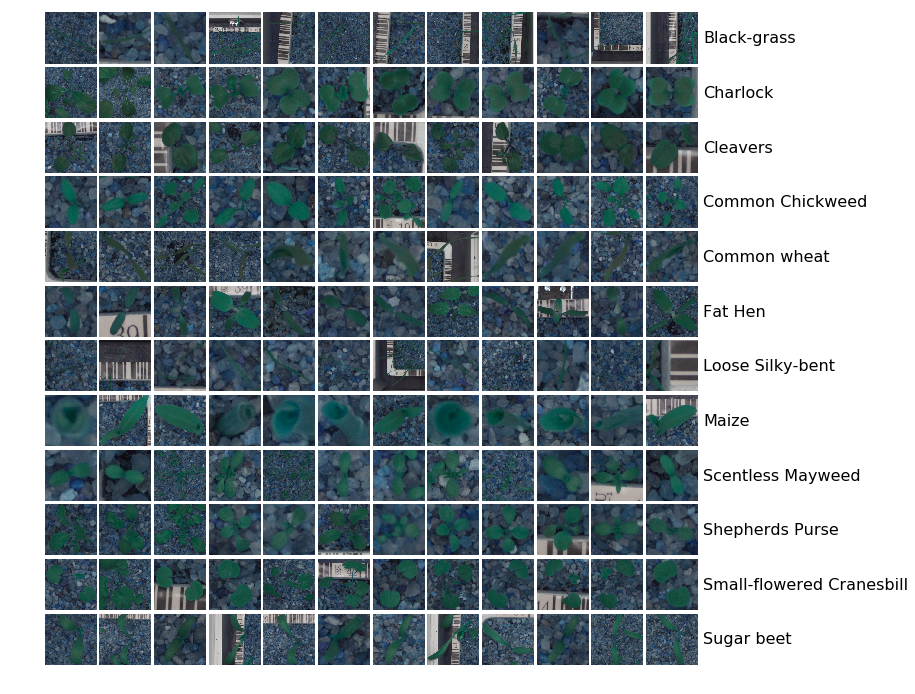

In [7]:
## show 12 images of all species of train data

if show_plots:

    fig = plt.figure(1, figsize=(num_species, num_species))
    grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_species, num_species), 
                                             axes_pad=0.05)
    i = 0
    for species_id, sp in enumerate(species):
        for filepath in train_df[train_df['species'] == sp]['filepath'].values[:num_species]:
            ax = grid[i]
            img = read_image(filepath, (224, 224))
            ax.imshow(img.astype(np.uint8))
            ax.axis('off')
            if i % num_species == num_species - 1:
                ax.text(250, 112, sp, verticalalignment='center')
            i += 1
    plt.show();

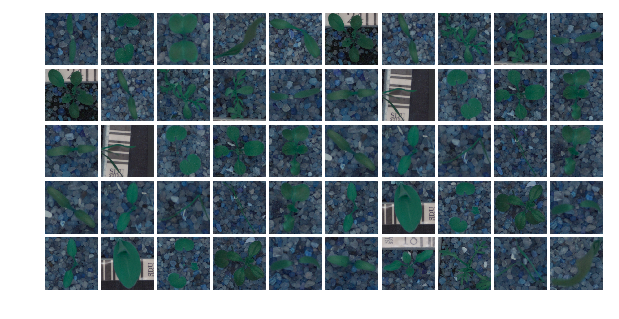

In [8]:
## show some test images 

if show_plots:

    fig = plt.figure(1, figsize=(10, 10))
    grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(5, 10), 
                                             axes_pad=0.05)
    i = 0
    for j in range(5):
        for filepath in test_df['filepath'].values[j*5:j*5+10]:
            ax = grid[i]
            img = read_image(filepath, (224, 224))
            ax.imshow(img.astype(np.uint8))
            ax.axis('off')
            i += 1
    plt.show();
    


# 3. Manipulate data
- detect and segment the plants in the images
- preprocess images to shape (299,299,3) with values in the range [-1,1]
- create numpy arrays with training/validation/test images

In [9]:
## take a fixed number of samples for testing purpose

if take_only_samples_of_train_data:
    train_df = pd.concat([train_df[train_df['species'] == sp][:num_samples_of_train_data_per_species] for sp in species])
    train_df.index = np.arange(len(train_df))

if take_only_samples_of_test_data:
    test_df = test_df[:num_samples_of_test_data]

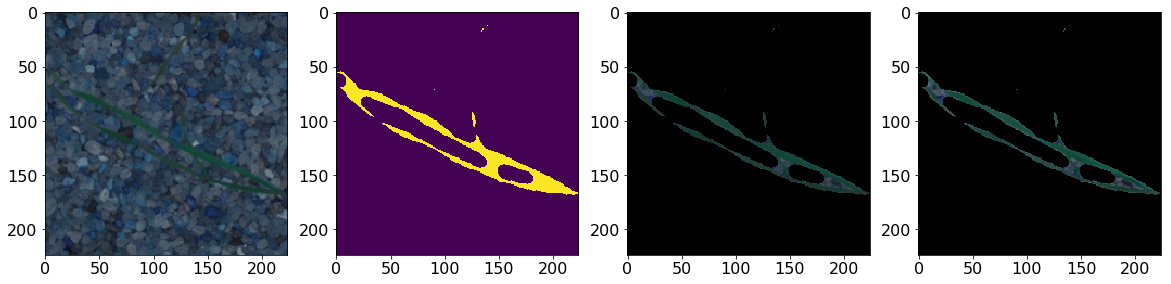

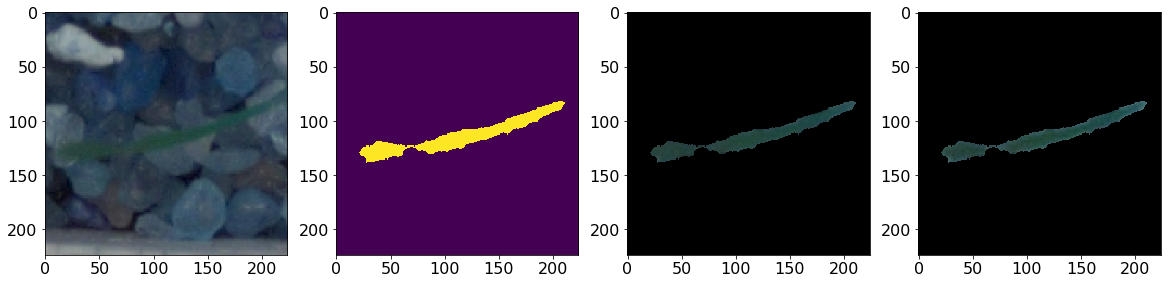

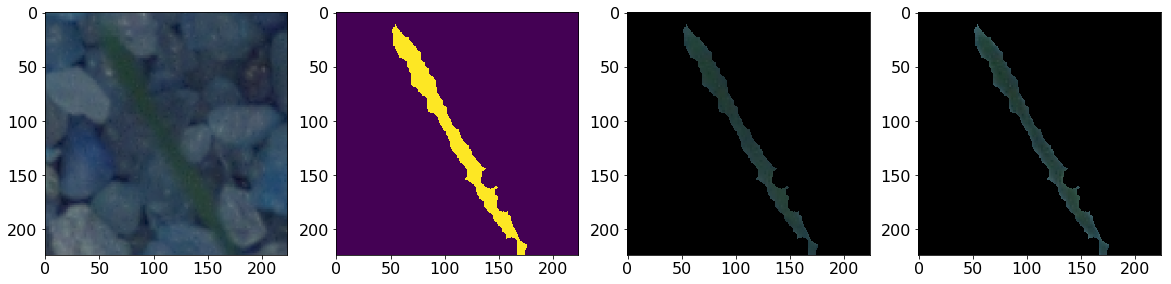

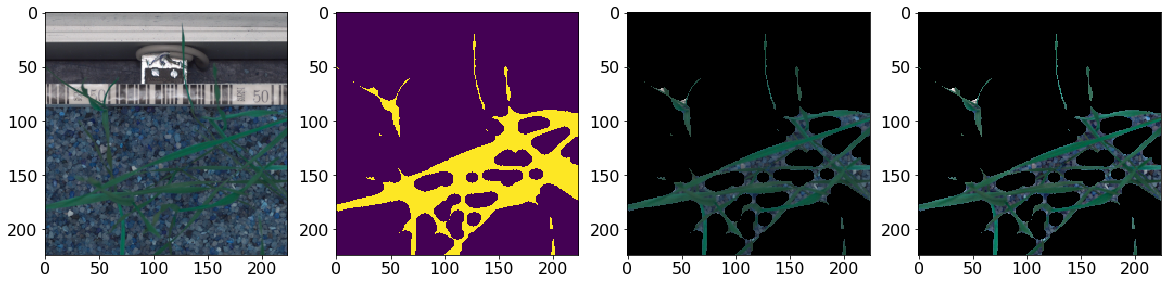

In [10]:
## detect and segment plants in the image 

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def read_segmented_image(filepath, img_size):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), img_size, interpolation = cv2.INTER_AREA)

    image_mask = create_mask_for_plant(img)
    image_segmented = segment_plant(img)
    image_sharpen = sharpen_image(image_segmented)
    return img, image_mask, image_segmented, image_sharpen
     

# show some images
if show_plots:
    for i in range(4):
 
        img, image_mask, image_segmented, image_sharpen = read_segmented_image(
            train_df.loc[i,'filepath'],(224,224))
        
        fig, axs = plt.subplots(1, 4, figsize=(20, 20))
        axs[0].imshow(img.astype(np.uint8))
        axs[1].imshow(image_mask.astype(np.uint8))
        axs[2].imshow(image_segmented.astype(np.uint8))
        axs[3].imshow(image_sharpen.astype(np.uint8))
        

In [11]:
## read and preprocess all training/validation/test images and labels

def preprocess_image(img):
    img /= 255.
    img -= 0.5
    img *= 2
    return img

target_image_size = 299

print('read and preprocess training and validation images')

# read, preprocess training and validation images  
x_train_valid = np.zeros((len(train_df), target_image_size, target_image_size, 3),
                         dtype='float32')
y_train_valid = train_df.loc[:, 'species_id'].values 
for i, filepath in tqdm(enumerate(train_df['filepath'])):
    
    # read original images
    #img = read_image(filepath, (target_image_size, target_image_size))
    
    # read segmented image
    _,_,_,img = read_segmented_image(filepath, (target_image_size, target_image_size))
    
    # all pixel values are now between -1 and 1
    x_train_valid[i] = preprocess_image(np.expand_dims(img.copy().astype(np.float), axis=0)) 

print('read and preprocess test images')

# read, preprocess test images  
x_test = np.zeros((len(test_df), target_image_size, target_image_size, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test_df['filepath'])):
    
    # read original image
    #img = read_image(filepath, (target_image_size, target_image_size))
    
    # read segmented image
    _,_,_,img = read_segmented_image(filepath, (target_image_size, target_image_size))
    
    # all pixel values are now between -1 and 1
    x_test[i] = preprocess_image(np.expand_dims(img.copy().astype(np.float), axis=0)) 
    
print('x_train_valid.shape = ', x_train_valid.shape)
print('x_test.shape = ', x_test.shape)


4it [00:00, 30.05it/s]

read and preprocess training and validation images


2400it [00:45, 53.22it/s]
9it [00:00, 81.68it/s]

read and preprocess test images


794it [00:09, 85.63it/s]

x_train_valid.shape =  (2400, 299, 299, 3)
x_test.shape =  (794, 299, 299, 3)


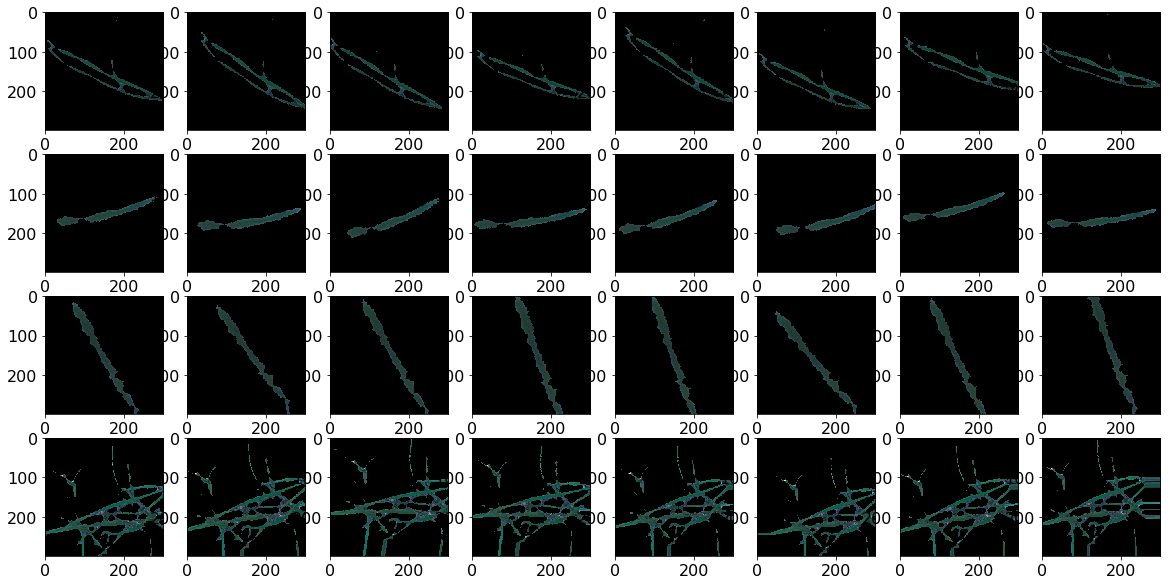

In [12]:
## data augmentation

# generate new images via rotations, translations, flippings
def generate_images(imgs):
    imgs_len = len(imgs)
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        horizontal_flip = False, vertical_flip = False, zoom_range = 0.1)

    imgs = image_generator.flow(imgs.copy(), np.zeros(imgs_len), batch_size=imgs_len, shuffle = False).next()    
  
    # return transformed images in the same order as the original ones
    return imgs[0]


# show some examples
if show_plots:
    imgs = (((x_train_valid[0:4]+1.)/2.)*255.) # transform pixels into range [0,255]
    imgs_generated = imgs

    fig, axs = plt.subplots(4, 8, figsize=(20, 10))
    for i in range(8):
        axs[0,i].imshow(imgs_generated[0].astype(np.uint8))
        axs[1,i].imshow(imgs_generated[1].astype(np.uint8))
        axs[2,i].imshow(imgs_generated[2].astype(np.uint8))
        axs[3,i].imshow(imgs_generated[3].astype(np.uint8))   
        imgs_generated = generate_images(imgs)



# 4. Extract bottleneck features from Xception
- compute or load the 2048 bottleneck features for each image

In [13]:
## copy xception models into ~.keras directory

# set True when running on kaggle
if running_on_kaggle:
    # create cache and models directory (only on kaggle)
    cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    models_dir = os.path.join(cache_dir, 'models')
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    # show available pretrained keras models
    !ls ../input/keras-pretrained-models/

    # copy xception models to models directory
    print('')
    print('use xception models')
    !cp ../input/keras-pretrained-models/xception* ~/.keras/models/
    !ls ~/.keras/models
    

Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5

use xception models
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [14]:
## compute or load bottleneck features from xception model

# train and validation images
if not load_bf_of_train_data:
    
    print('x_train_valid.shape = ', x_train_valid.shape)
    print('y_train_valid.shape = ', y_train_valid.shape)
    print('')

    print('compute bottleneck features from Xception network')

    local_start = datetime.datetime.now()
    
    # load xception base model and predict the last layer comprising 2048 neurons per image
    base_model = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
    x_train_valid_bf = base_model.predict(x_train_valid, batch_size=32, verbose=1)

    print('running time: ', datetime.datetime.now()-local_start)    
    print('')
    print('x_train_valid_bf.shape = ', x_train_valid_bf.shape)

    print('')
    print('save bottleneck features and labels for later ')
    np.save(os.path.join(os.getcwd(),'x_train_valid_bf.npy'), x_train_valid_bf)
    np.save(os.path.join(os.getcwd(),'y_train_valid.npy'), y_train_valid)

else:    
    # load bottleneck features and labels
    
    print('load bottleneck features and labels')
    
    x_train_valid_bf = np.load(os.path.join(os.getcwd(),'x_train_valid_bf_of_segmented_images.npy'))
    y_train_valid = np.load(os.path.join(os.getcwd(),'y_train_valid_of_segmented_images.npy'))

    print('x_train_valid_bf.shape = ', x_train_valid_bf.shape)
    print('y_train_valid.shape = ', y_train_valid.shape)
    
# test images
if not load_bf_of_test_data:
    # compute bottleneck features from xception model
    
    local_start = datetime.datetime.now()
    
    # load xception base model and predict the last layer comprising 2048 neurons per image
    base_model = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
    x_test_bf = base_model.predict(x_test, batch_size=32, verbose=1)
    
    print('running time: ', datetime.datetime.now()-local_start)    
    print('')
    print('x_test_bf = ',x_test_bf.shape)

    print('save bottleneck features ')
    np.save(os.path.join(os.getcwd(),'x_test_bf.npy'), x_test_bf)

else:
    # load bottleneck features and compute the predictions
    print('load bottleneck features')
    x_test_bf = np.load(os.path.join(os.getcwd(),'x_test_bf_of_segmented_images.npy'))
    print('x_test_bf.shape = ', x_test_bf.shape)
    

x_train_valid.shape =  (2400, 299, 299, 3)
y_train_valid.shape =  (2400,)

compute bottleneck features from Xception network
2400/2400 [==============================] - 1242s 517ms/step
running time:  0:20:45.855496

x_train_valid_bf.shape =  (2400, 2048)

save bottleneck features and labels for later 
794/794 [==============================] - 405s 510ms/step
running time:  0:06:48.750204

x_test_bf =  (794, 2048)
save bottleneck features 


In [15]:
## compute or load bottleneck features for augmented data

if use_aug_data:

    if not load_bf_of_aug_data:

        for i in range(2):
            x_aug_tmp = generate_images(x_train_valid)
            y_aug_tmp = y_train_valid

            print('compute bottleneck features from Xception network')
            print('x_aug_tmp.shape = ', x_aug_tmp)
            print('y_aug_tmp.shape = ', y_aug_tmp)

            local_start = datetime.datetime.now()

            # load xception model and predict the last layer having 2048 neurons per image
            base_model = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
            x_aug_tmp_bf = base_model.predict(x_aug_tmp, batch_size=32, verbose=1)
            
            print('running time: ', datetime.datetime.now()-local_start)    
            print('')
            print('x_aug_tmp_bf.shape = ', x_aug_tmp_bf.shape)
            
            if i==0:
                x_aug = x_aug_tmp_bf
                y_aug = y_aug_tmp
            else:
                x_aug = np.concatenate([x_aug,x_aug_tmp_bf])
                y_aug = np.concatenate([y_aug,y_aug_tmp])
            
            print('')
            print('save bottleneck features and labels for later ')
            np.save(os.path.join(os.getcwd(),'x_aug.npy'), x_aug)
            np.save(os.path.join(os.getcwd(),'y_aug.npy'), y_aug)

     
    else:
        # load bottleneck features and compute the predictions

        print('load bottleneck features')
        x_aug_bf = np.load(os.path.join(os.getcwd(), 'x_aug_bf_of_segmented_images.npy'))
        y_aug = np.load(os.path.join(os.getcwd(), 'y_aug_of_segmented_images.npy'))

        print('x_aug_bf.shape = ', x_aug_bf.shape)
        print('y_aug.shape = ', y_aug.shape)
   

In [16]:
## combine files
if False:
    x_aug_bf_1 = np.load(os.path.join(os.getcwd(), 'x_aug_bf_of_segmented_images.npy'))
    y_aug_1 = np.load(os.path.join(os.getcwd(), 'y_aug_of_segmented_images.npy'))
    print(x_aug_bf_1.shape, y_aug_1.shape)
    x_aug_bf_2 = np.load(os.path.join(os.getcwd(), 'x_aug_bf.npy'))
    y_aug_2 = np.load(os.path.join(os.getcwd(), 'y_aug.npy'))
    print(x_aug_bf_2.shape, y_aug_2.shape)
    x_aug_bf = np.concatenate([x_aug_bf_1,x_aug_bf_2])
    y_aug = np.concatenate([y_aug_1,y_aug_2])
    print(x_aug_bf.shape,y_aug.shape)
    #np.save(os.path.join(os.getcwd(),'x_aug_bf.npy'), x_aug_bf)
    #np.save(os.path.join(os.getcwd(),'y_aug.npy'), y_aug)


# 5. Train and validate models
- try out logistic regression, random forest, a neural network
- validate the models and choose the best predictions

In [17]:
# split data into training and validation sets
#set_seed = 123

# use one-hot encoding for categorial labels
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

# function to shuffle randomly train and validation data
def shuffle_train_valid_data():
    
    print('shuffle train and validation data')
    
    # shuffle train and validation data of original data
    perm_array = np.arange(len(x_train_valid_bf)) 
    np.random.shuffle(perm_array)
    
    # split train and validation sets based on original data
    x_train_bf = x_train_valid_bf[perm_array[:train_set_size]]
    y_train = dense_to_one_hot(y_train_valid[perm_array[:train_set_size]], num_species)
    x_valid_bf = x_train_valid_bf[perm_array[-valid_set_size:]]
    y_valid = dense_to_one_hot(y_train_valid[perm_array[-valid_set_size:]], num_species)
    
    # augment train data by generated images
    if use_aug_data:
        
        x_train_bf = np.concatenate([x_train_bf, x_aug_bf])
        y_train = np.concatenate([y_train, dense_to_one_hot(y_aug, num_species)])
        
        # shuffle data
        perm_array = np.arange(len(x_train_bf)) 
        np.random.shuffle(perm_array)
        
        x_train_bf = x_train_bf[perm_array]
        y_train = y_train[perm_array]
         
    return x_train_bf, y_train, x_valid_bf, y_valid 

if valid_set_size_percentage > 0:
    # split into train and validation sets
    valid_set_size = int(len(x_train_valid_bf) * valid_set_size_percentage/100);
    train_set_size = len(x_train_valid_bf) - valid_set_size;
else:
    # train on all available data
    valid_set_size = int(len(x_train_valid_bf) * 0.1);
    train_set_size = len(x_train_valid_bf)

# split into train and validation sets including shuffling
x_train_bf, y_train, x_valid_bf, y_valid = shuffle_train_valid_data() 

print('x_train_bf.shape = ', x_train_bf.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid_bf.shape = ', x_valid_bf.shape)
print('y_valid.shape = ', y_valid.shape)

shuffle train and validation data
x_train_bf.shape =  (2160, 2048)
y_train.shape =  (2160, 12)
x_valid_bf.shape =  (240, 2048)
y_valid.shape =  (240, 12)


In [18]:
## logistic regression

cv_num = 1

acc_logreg_train = acc_logreg_valid = 0
y_test_pred_proba_logreg = 0

for i in range(cv_num):
    
    shuffle_train_valid_data() # shuffle data
    
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    logreg.fit(x_train_bf, one_hot_to_dense(y_train))
   
    acc_logreg_train += logreg.score(x_train_bf, one_hot_to_dense(y_train))
    acc_logreg_valid += logreg.score(x_valid_bf, one_hot_to_dense(y_valid))

    y_test_pred_proba_logreg += logreg.predict_proba(x_test_bf)
    
acc_logreg_train /= cv_num
acc_logreg_valid /= cv_num
y_test_pred_proba_logreg /= cv_num
y_test_pred_class_logreg = np.argmax(y_test_pred_proba_logreg, axis = 1)

print('Logistic Regression')
print('Accuracy train/valid = %.4f/%.4f'%(acc_logreg_train, acc_logreg_valid))
print('y_test_pred_class_logreg.shape = ', y_test_pred_class_logreg.shape)

shuffle train and validation data
Logistic Regression
Accuracy train/valid = 0.9995/0.8792
y_test_pred_class_logreg.shape =  (794,)


In [19]:
## random forest

random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=10)
random_forest.fit(x_train_bf, one_hot_to_dense(y_train))

acc_train_random_forest = random_forest.score(x_train_bf, one_hot_to_dense(y_train))
acc_valid_random_forest = random_forest.score(x_valid_bf, one_hot_to_dense(y_valid))

print('Random Forest')
print('Accuracy train/valid = %.4f/%.4f'%(acc_train_random_forest, acc_valid_random_forest))

Random Forest
Accuracy train/valid = 0.9995/0.7125


In [20]:
## neural network with tensorflow

# permutation array for shuffling train data
perm_array_train = np.arange(len(x_train_bf)) 
index_in_epoch = 0

# function: to get the next mini batch
def get_next_batch(batch_size):
    
    global index_in_epoch, perm_array_train
  
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > train_set_size:
        np.random.shuffle(perm_array_train) # shuffle data
        start = 0 # start next epoch
        index_in_epoch = batch_size
              
    end = index_in_epoch
    
    return x_train_bf[perm_array_train[start:end]], y_train[perm_array_train[start:end]]

x_size = x_train_bf.shape[1] # number of features
y_size = num_species # binary variable
n_n_fc1 = 1024 # number of neurons of first layer
n_n_fc2 = num_species # number of neurons of second layer

# variables for input and output 
x_data = tf.placeholder('float', shape=[None, x_size])
y_data = tf.placeholder('float', shape=[None, y_size])

# 1.layer: fully connected
W_fc1 = tf.Variable(tf.truncated_normal(shape = [x_size, n_n_fc1], stddev = 0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape = [n_n_fc1]))  
h_fc1 = tf.nn.relu(tf.matmul(x_data, W_fc1) + b_fc1)

# add dropout
tf_keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, tf_keep_prob)

# 3.layer: fully connected
W_fc2 = tf.Variable(tf.truncated_normal(shape = [n_n_fc1, n_n_fc2], stddev = 0.1)) 
b_fc2 = tf.Variable(tf.constant(0.1, shape = [n_n_fc2]))  
z_pred = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# cost function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_data, 
                                                                       logits=z_pred));

# optimisation function
tf_learn_rate = tf.placeholder(dtype='float', name="tf_learn_rate")
train_step = tf.train.AdamOptimizer(tf_learn_rate).minimize(cross_entropy)

# evaluation
y_pred = tf.cast(tf.nn.softmax(z_pred), dtype = tf.float32);
y_pred_class = tf.cast(tf.argmax(y_pred,1), tf.int32)
y_data_class = tf.cast(tf.argmax(y_data,1), tf.int32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_class, y_data_class), tf.float32))

# parameters
cv_num = 1 # number of cross validations
n_epoch = 15 # number of epochs
batch_size = 50 
keep_prob = 0.33 # dropout regularization with keeping probability
learn_rate_range = [0.01,0.005,0.0025,0.001,0.001,0.001,0.00075,0.0005,0.00025,0.0001,
                   0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001];
learn_rate_step = 3 # in terms of epochs

acc_train_DNN = 0
acc_valid_DNN = 0
loss_train_DNN = 0
loss_valid_DNN = 0
y_test_pred_proba_DNN = 0
y_valid_pred_proba = 0

# use cross validation
for j in range(cv_num):
    
    # start TensorFlow session and initialize global variables
    sess = tf.InteractiveSession() 
    sess.run(tf.global_variables_initializer())  

    # shuffle train/validation splits
    shuffle_train_valid_data() 
    n_step = -1;

    # training model
    for i in range(int(n_epoch*train_set_size/batch_size)):

        if i%int(learn_rate_step*train_set_size/batch_size) == 0:
            n_step += 1;
            learn_rate = learn_rate_range[n_step];
            print('learnrate = ', learn_rate)
        
        x_batch, y_batch = get_next_batch(batch_size)
        
        sess.run(train_step, feed_dict={x_data: x_batch, y_data: y_batch, 
                                        tf_keep_prob: keep_prob, 
                                        tf_learn_rate: learn_rate})

        if i%int(0.25*train_set_size/batch_size) == 0:
            
            train_loss = sess.run(cross_entropy,
                                  feed_dict={x_data: x_train_bf[:valid_set_size], 
                                             y_data: y_train[:valid_set_size], 
                                             tf_keep_prob: 1.0})

            
            train_acc = accuracy.eval(feed_dict={x_data: x_train_bf[:valid_set_size], 
                                                 y_data: y_train[:valid_set_size], 
                                                 tf_keep_prob: 1.0})    

            valid_loss = sess.run(cross_entropy,feed_dict={x_data: x_valid_bf, 
                                                           y_data: y_valid, 
                                                           tf_keep_prob: 1.0})

           
            valid_acc = accuracy.eval(feed_dict={x_data: x_valid_bf, 
                                                 y_data: y_valid, 
                                                 tf_keep_prob: 1.0})      

            print('%.2f epoch: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(
                (i+1)*batch_size/train_set_size, train_loss, valid_loss, train_acc, valid_acc))

    
    acc_train_DNN += train_acc
    acc_valid_DNN += valid_acc
    loss_train_DNN += train_loss
    loss_valid_DNN += valid_loss
    
    y_valid_pred_proba += y_pred.eval(feed_dict={x_data: x_valid_bf, tf_keep_prob: 1.0}) 
    y_test_pred_proba_DNN += y_pred.eval(feed_dict={x_data: x_test_bf, tf_keep_prob: 1.0}) 

    sess.close()
        
acc_train_DNN /= float(cv_num)
acc_valid_DNN /= float(cv_num)
loss_train_DNN /= float(cv_num)
loss_valid_DNN /= float(cv_num)

# final validation prediction
y_valid_pred_proba /= float(cv_num)
y_valid_pred_class = np.argmax(y_valid_pred_proba, axis = 1)

# final test prediction
y_test_pred_proba_DNN /= float(cv_num)
y_test_pred_class_DNN = np.argmax(y_test_pred_proba_DNN, axis = 1)

# final loss and accuracy
print('')
print('final: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(loss_train_DNN, 
                                                                      loss_valid_DNN, 
                                                                      acc_train_DNN, 
                                                                      acc_valid_DNN))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

shuffle train and validation data
learnrate =  0.01
0.02 epoch: train/val loss = 12.9103/14.4182, train/val acc = 0.2375/0.1917
0.25 epoch: train/val loss = 1.6807/2.3750, train/val acc = 0.6583/0.5375
0.49 epoch: train/val loss = 0.9427/1.5585, train/val acc = 0.7583/0.6875
0.72 epoch: train/val loss = 0.6603/0.8202, train/val acc = 0.7667/0.7500
0.95 epoch: train/val loss = 0.4749/0.6298, train/val acc = 0.8167/0.7708
1.18 epoch: train/val loss = 0.4191/0.6324, train/val acc = 0.8333/0.7667
1.41 epoch: train/val loss = 0.4459/0.5866, train/val acc = 0.8500/0.7792
1.64 epoch: train/val loss = 0.4859/0.6530, train/val acc = 0.8125/0.7458
1.88 epoch: train/val loss = 0.3884/0.5830, train/val acc = 0.8583/0.8167
2.11 epoch: train/val loss = 0.3475/0.5619, train/val acc = 0.8625/0.8042
2.34 epoch: train

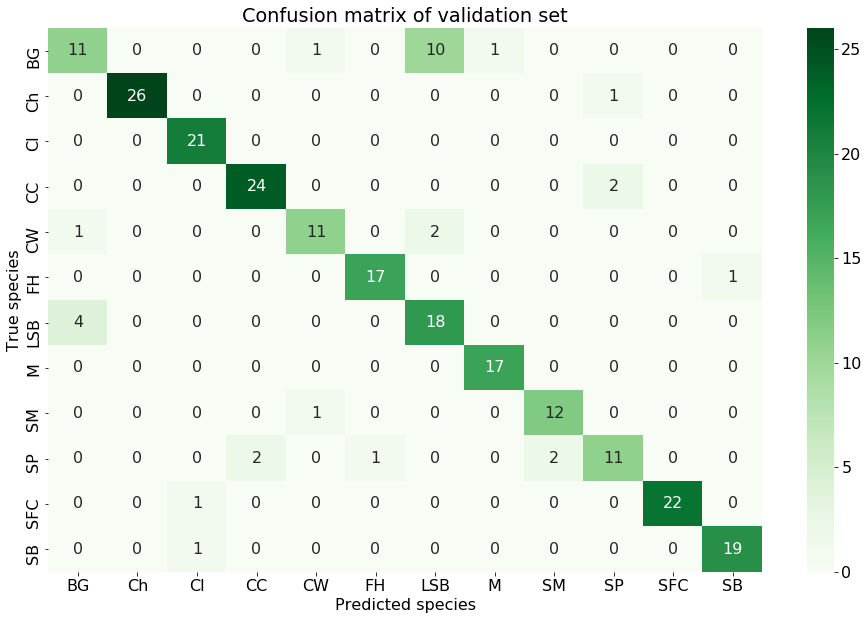

In [21]:
## show confusion matrix

if show_plots:
    
    cnf_matrix = confusion_matrix(one_hot_to_dense(y_valid), y_valid_pred_class)

    abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
    pd.DataFrame({'class': species, 'abbreviation': abbreviation})

    fig, ax = plt.subplots(1)
    ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
    ax.set_xticklabels(abbreviation)
    ax.set_yticklabels(abbreviation)
    plt.title('Confusion matrix of validation set')
    plt.ylabel('True species')
    plt.xlabel('Predicted species')
    plt.show();
    

# 6. Predict species and submit test results
- take the results from the best model or a combination
- write the submission file

In [22]:
## choose prediction

#y_test_pred_class = y_test_pred_class_DNN
y_test_pred_class = y_test_pred_class_logreg


In [23]:
## submit test results

test_df['species_id'] = y_test_pred_class
test_df['species'] = [species[sp] for sp in y_test_pred_class]
test_df[['file', 'species']].to_csv('submission.csv', index=False)

In [24]:
print('total running time: ', datetime.datetime.now()-global_start)

total running time:  0:29:24.257998
